# Data Exploration

In [4]:
%load_ext autoreload
%autoreload 2

from assaiku.data import DataConfig

from assaiku.model.configs import EvaluationConfig
from assaiku.model.evaluation import evaluate_model
from assaiku.model.processors import (
    fit_processor,
    initialize_feat_processor,
    split_transform,
)
from assaiku.model.train import initialize_model, train_model
from assaiku.model.evaluation import analyze_data
from assaiku.model.configs import LogisticRegressionConfig, EvaluationConfig, LinearSVMConfig, XGBConfig
from assaiku.model import MLPipe

import pandas as pd

pd.set_option('display.max_columns', 50)

data_config = DataConfig(perform_exploration=True)
model_config = XGBConfig(n_estimators=100,
        max_depth=7,
        learning_rate=1e-1,
        dimension_red=None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data generated by Data Pipeline

In [5]:
train_data = pd.read_parquet(path=data_config.train_data_out)
test_data = pd.read_parquet(path=data_config.test_data_out)

## Initiliaze the data processor and fit it

In [6]:
feat_processor, label_binarizer = initialize_feat_processor(
                data_config=data_config, model_config=model_config
            )
fit_processor(
    train_data=train_data,
    feature_cols=data_config.features,
    pipeline=feat_processor,
)

## Split and transform data for each data set

In [7]:
x_train, y_train, w_train = split_transform(
                train_data,
                feat_processor,
                label_binarizer,
                data_config=data_config,
            )
x_test, y_test, w_test = split_transform(
    test_data,
    feat_processor,
    label_binarizer,
    data_config=data_config,
)

## Train model

In [18]:
model = initialize_model(model_config=model_config)

train_model(
    model_config=model_config,
    x_train=x_train,
    y_train=y_train,
    weights=w_train,
    model=model,
)

Training model XGB(dimred=False)
Positive weights set to 3.925207024475412
Negative weights set to 1.0341225738753932


## Evaluate model

In [19]:
train_perf_0, train_perf_1 = evaluate_model(
    model=model,
    x=x_train,
    y=y_train,
    weights=w_train,
    data_set="train",
    model_name=model_config.name,
)

test_perf_0, test_perf_1 = evaluate_model(
    model=model,
    x=x_test,
    y=y_test,
    weights=w_test,
    data_set="test",
    model_name=model_config.name,
)

Evaluating on train set
Model = XGB(dimred=False) - Precision [0.98273045 0.57370812] - Recall [0.96097349 0.7567017 ] - F1 [0.9717302  0.65261983]
Evaluating on test set
Model = XGB(dimred=False) - Precision [0.98037057 0.54034127] - Recall [0.95833419 0.71851377] - F1 [0.96922714 0.61681866]


## Compare different models in one line

Fitting processor for model XGB(dimred=False)
Model XGB(dimred=False) | Repet [1/2]
Training model XGB(dimred=False)
Positive weights set to 3.925207024475412
Negative weights set to 1.0341225738753932
Evaluating on train set
Model = XGB(dimred=False) - Precision [0.98273045 0.57370812] - Recall [0.96097349 0.7567017 ] - F1 [0.9717302  0.65261983]
Evaluating on test set
Model = XGB(dimred=False) - Precision [0.98037057 0.54034127] - Recall [0.95833419 0.71851377] - F1 [0.96922714 0.61681866]
Model XGB(dimred=False) | Repet [2/2]
Training model XGB(dimred=False)
Positive weights set to 3.925207024475412
Negative weights set to 1.0341225738753932
Evaluating on train set
Model = XGB(dimred=False) - Precision [0.98273045 0.57370812] - Recall [0.96097349 0.7567017 ] - F1 [0.9717302  0.65261983]
Evaluating on test set
Model = XGB(dimred=False) - Precision [0.98037057 0.54034127] - Recall [0.95833419 0.71851377] - F1 [0.96922714 0.61681866]
Fitting processor for model XGB(dimred=True)
Model X

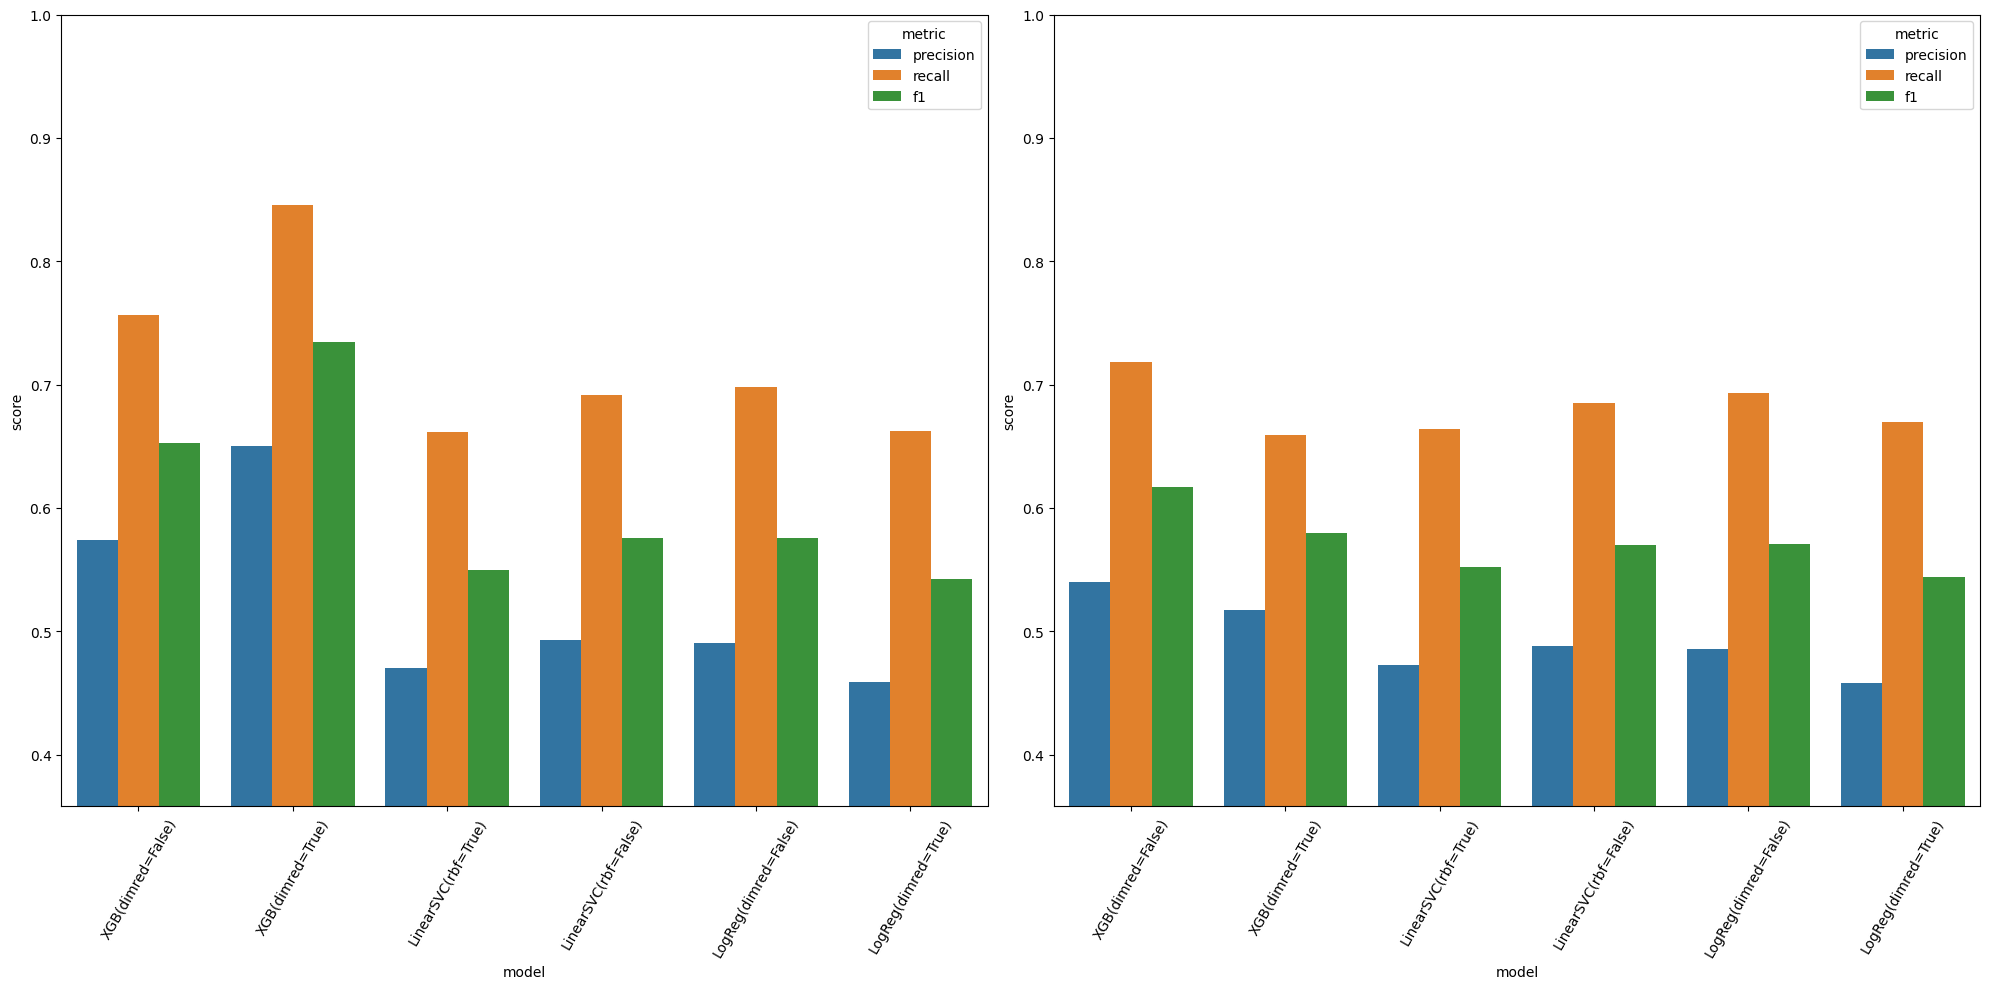

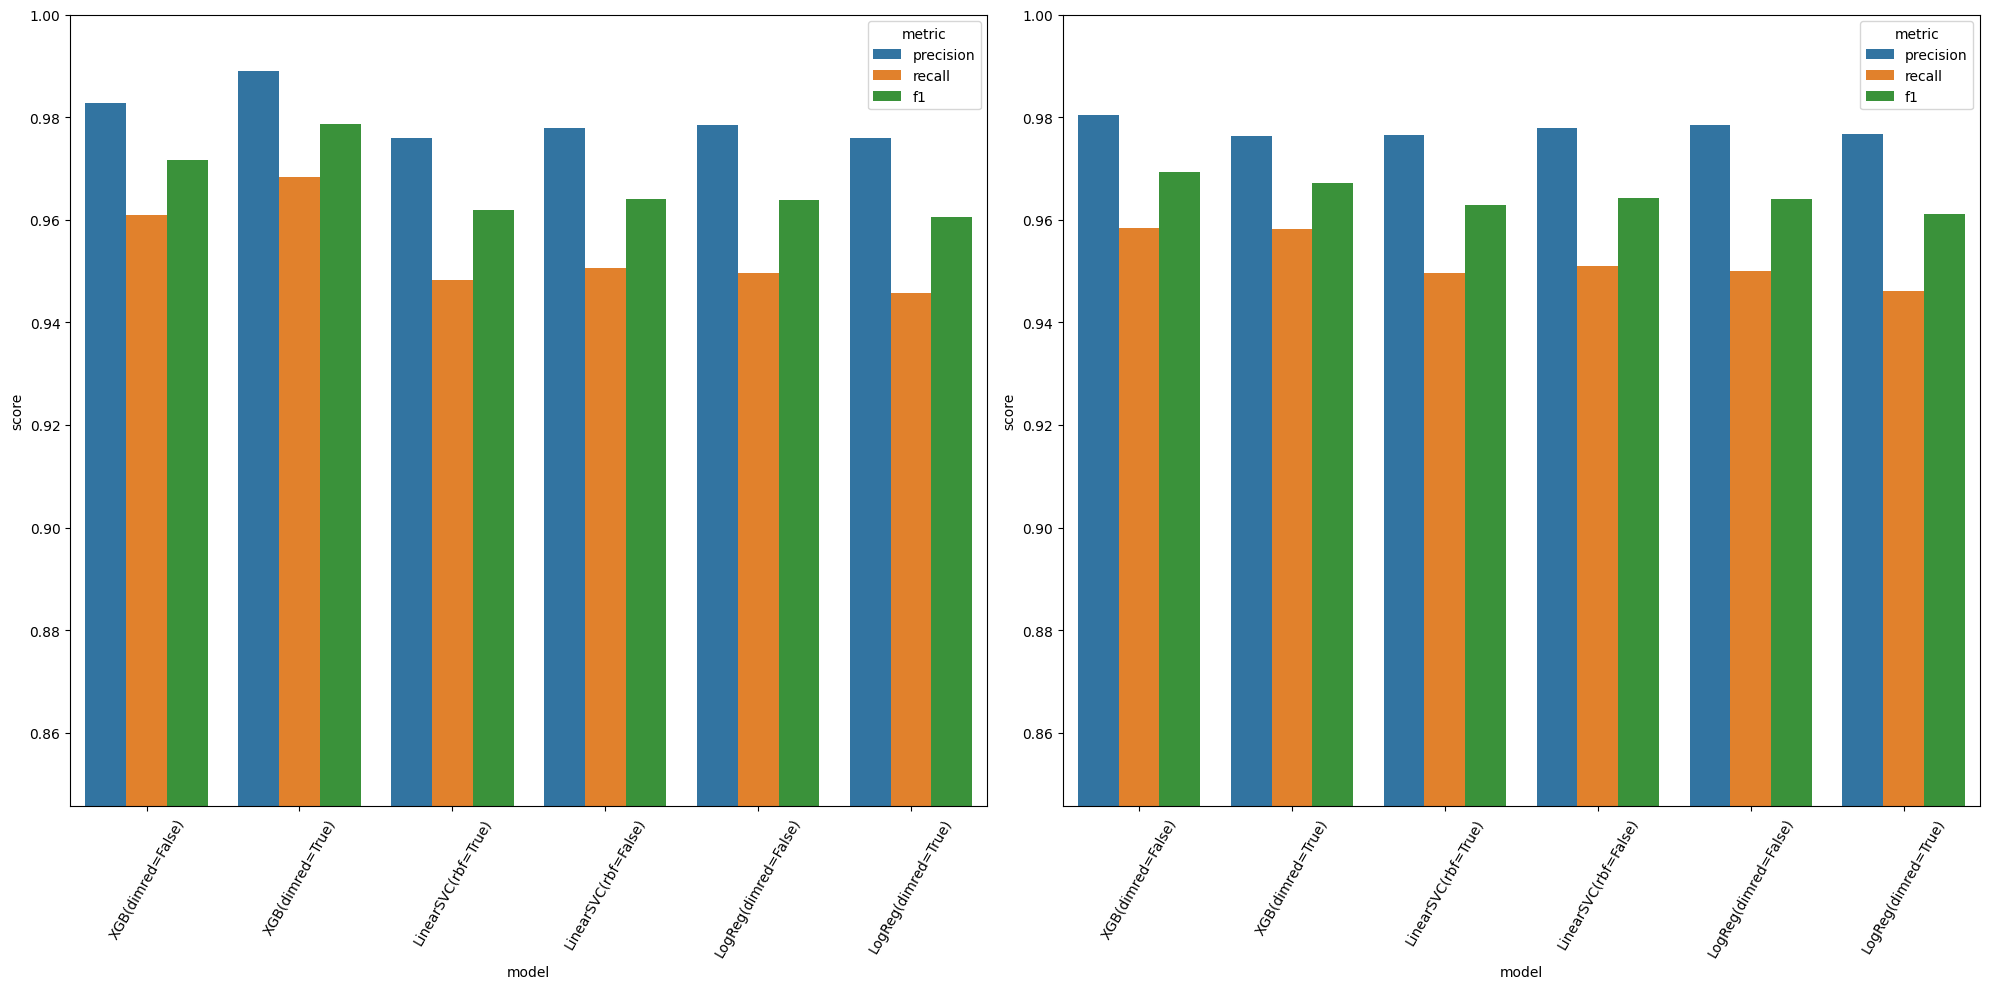

In [20]:
# Specify your evaluation config here
eval_config = EvaluationConfig(n_repet=2,
                            model_configs=[
                                XGBConfig(n_estimators=100,
                                            max_depth=7,
                                            learning_rate=1e-1,
                                            dimension_red=None),
                                XGBConfig(weight_neg_factor=1, 
                                            weight_pos_factor=1,
                                            dimension_red=50),
                                LinearSVMConfig(rbf_gamma=5e-5, C=100),
                                LinearSVMConfig(),
                                LogisticRegressionConfig(),
                                LogisticRegressionConfig(dimension_red=50),
                            ])

ml_pipeline = MLPipe(data_config=data_config,
                     evaluation_config=eval_config)

data = ml_pipeline.run()